In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruit-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F500992%2F928052%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T151802Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D12bbf9a3833e3f81b457e654337291cb221e7305742723e96c39a6f4c90c5b746e08e7fb71adbfa47b11a99f9cd6e009b07b1bf69b43a29bd0e2e3ae01e91f566a6511657f7f3d1d555b2c99681b556c76eda03baf6510872272402c20130f3194879a7e2cb4ac028c2acc725f0ae9281162e22a96357a6098f7407df5ece0e5d3ef0a9ff36c7d8c3e207161b89ec7da4295e9d3ff05823a5e860efc1beb7a69ce7dfea2c186e7b17cb538292d1f7d79dec18d623fbf51fe0fd894bc3b2b4e657620d815002890918196312455acadc8de0928f5851112bb2c89c478abfaa167630ee04527d5fa0172ab53b43e936f5b21f896cb1974e53751f0af0b1e0ad751'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8501391916 bytes downloaded
Downloaded and uncompressed: fruit-recognition
Data source import complete.


# Fruit recognition with simple neural network

In this notebook, using the Fruit Recognition dataset, we will attempt to classify images of various fruits using a simple neural network.

# Import the necessary libraries

In [11]:
import os
import shutil
import torch
import torchvision
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


## Exploring and preparing data

# Create new folders for transferring the necessary files

In [12]:
import os

directories = ['Apple', 'Carambola', 'Pomegranate', 'Pear', 'Plum', 'Tomatoes', 'Muskmelon']
parent_dir = '/kaggle/working'

for directory in directories:
    path = os.path.join(parent_dir, directory)
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print(f"The directory '{directory}' already exists.")

# Additional code if needed...


The directory 'Apple' already exists.
The directory 'Carambola' already exists.
The directory 'Pomegranate' already exists.
The directory 'Pear' already exists.
The directory 'Plum' already exists.
The directory 'Tomatoes' already exists.
The directory 'Muskmelon' already exists.


*The code creates directories for various fruits in the '/kaggle/working' directory using a list of fruit names. It then prints the list of files and directories in that location.*

# Transfer the necessary files to the created directories

In [13]:
import os
import shutil

sources = [
    '../input/fruit-recognition/Apple/Total Number of Apples',
    '../input/fruit-recognition/Carambola',
    '../input/fruit-recognition/Pomegranate',
    '../input/fruit-recognition/Pear',
    '../input/fruit-recognition/Plum',
    '../input/fruit-recognition/Tomatoes',
    '../input/fruit-recognition/muskmelon'
]

destinations = [
    '../output/kaggle/working/Apple',
    '../output/kaggle/working/Carambola',
    '../output/kaggle/working/Pomegranate',
    '../output/kaggle/working/Pear',
    '../output/kaggle/working/Plum',
    '../output/kaggle/working/Tomatoes',
    '../output/kaggle/working/Muskmelon'
]

for i in range(len(sources)):
    source = sources[i]
    destination = destinations[i]

    if not os.path.exists(destination):
        shutil.copytree(source, destination)
    else:
        print(f"The directory '{destination}' already exists. Skipping copying.")


The directory '../output/kaggle/working/Apple' already exists. Skipping copying.
The directory '../output/kaggle/working/Carambola' already exists. Skipping copying.
The directory '../output/kaggle/working/Pomegranate' already exists. Skipping copying.
The directory '../output/kaggle/working/Pear' already exists. Skipping copying.
The directory '../output/kaggle/working/Plum' already exists. Skipping copying.
The directory '../output/kaggle/working/Tomatoes' already exists. Skipping copying.
The directory '../output/kaggle/working/Muskmelon' already exists. Skipping copying.


*The code copies directory structures from source paths representing various fruit categories to corresponding destination paths. It utilizes `shutil.copytree` in a loop to recursively copy entire directory trees, facilitating the organization and relocation of fruit recognition data from input directories to designated output directories.*

# Let's inspect the classes that resulted from the created directories

In [14]:
data_dir = '../output/kaggle/working'
classes = os.listdir(data_dir)
print(classes)

['Tomatoes', 'Muskmelon', 'Plum', 'Carambola', 'Pomegranate', 'Apple', 'Pear']



*The code initializes a variable data_dir with the path '../output/kaggle/working' and retrieves a list of classes (subdirectories) within that directory using os.listdir. It then prints the list of classes, providing an overview of the available fruit categories or classes for further processing.*

# Resize the original images to a uniform size and transform them into tensors

In [15]:
dsize = (248, 248)
composed = Compose([Resize(dsize), ToTensor()])

dataset = ImageFolder(data_dir, composed)
len(dataset)

18830

*The code resizes images in the '../output/kaggle/working' directory to dimensions (248, 248) and converts them to PyTorch tensors. It then creates an ImageFolder dataset, organizing the images into classes, and returns the total number of images.*

# Count the number of elements in each class

In [16]:
class_count = collections.Counter(classes[label] for img, label in dataset)
class_count

Counter({'Tomatoes': 5024,
         'Muskmelon': 2080,
         'Plum': 2078,
         'Carambola': 3012,
         'Pomegranate': 2298,
         'Apple': 2167,
         'Pear': 2171})

*The corrected code uses `collections.Counter` to count the occurrences of each class label in the dataset. It iterates over image-label pairs, extracts the label, and creates a counter object (`class_count`) to store the frequency of each unique label.*

# Check the number of classes

In [17]:
len(classes)

7

# Let's take a look at a single element in the dataset

In [18]:
img, label = dataset[5]
print(img.shape, label)
img

torch.Size([3, 248, 248]) 0


tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.2392, 0.2392, 0.2392],
         [0.5255, 0.5255, 0.5255,  ..., 0.2392, 0.2392, 0.2392],
         [0.5255, 0.5255, 0.5255,  ..., 0.2392, 0.2392, 0.2392],
         ...,
         [0.7882, 0.7529, 0.7176,  ..., 0.7647, 0.7647, 0.7843],
         [0.7882, 0.7529, 0.6941,  ..., 0.7608, 0.7608, 0.7647],
         [0.7608, 0.7216, 0.6784,  ..., 0.7686, 0.7686, 0.7647]],

        [[0.5451, 0.5451, 0.5451,  ..., 0.2471, 0.2471, 0.2471],
         [0.5765, 0.5765, 0.5765,  ..., 0.2471, 0.2471, 0.2471],
         [0.5647, 0.5647, 0.5647,  ..., 0.2471, 0.2471, 0.2471],
         ...,
         [0.8157, 0.7804, 0.7451,  ..., 0.7765, 0.7765, 0.7961],
         [0.8157, 0.7804, 0.7216,  ..., 0.7725, 0.7725, 0.7765],
         [0.7882, 0.7490, 0.7059,  ..., 0.7922, 0.7922, 0.7765]],

        [[0.5373, 0.5373, 0.5373,  ..., 0.2549, 0.2549, 0.2549],
         [0.5765, 0.5765, 0.5765,  ..., 0.2549, 0.2549, 0.2549],
         [0.5725, 0.5725, 0.5725,  ..., 0.2549, 0.2549, 0.

*The code extracts an image and its corresponding label from the dataset at index 5. It then prints the shape of the image tensor (`img.shape`) and the associated label (`label`). The line `img .  explain` seems to be incomplete and does not have a valid function or method call.*

# Define a function to display a single element

Label:  Apple (0)


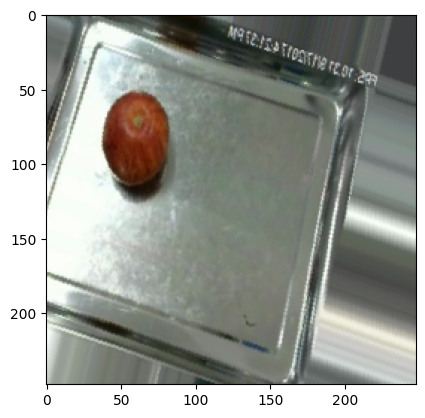

In [19]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[5])

*The `show_example` function takes an image tensor and its label, prints the class name and numerical label, and displays the image using matplotlib. It provides a convenient way to visualize dataset examples.*

# Create training and validation sets from the original dataset

In [20]:
torch.manual_seed(43)

val_size = 1500
test_size = 3000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(14330, 1500, 3000)

*This code sets a manual seed for PyTorch, then splits the dataset into training, validation, and test sets using `torch.utils.data.random_split`. It specifies the sizes for each set and prints their respective lengths.*

# Set the batch size and create loaders for the resulting datasets using DataLoader

In [21]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


*The code configures PyTorch `DataLoader` objects for training, validation, and test sets, facilitating batched data loading. It defines batch sizes, shuffling for training, and parameters for parallel loading, enhancing efficiency during neural network training and evaluation.*

# Display one batch

images.shape: torch.Size([32, 3, 248, 248])


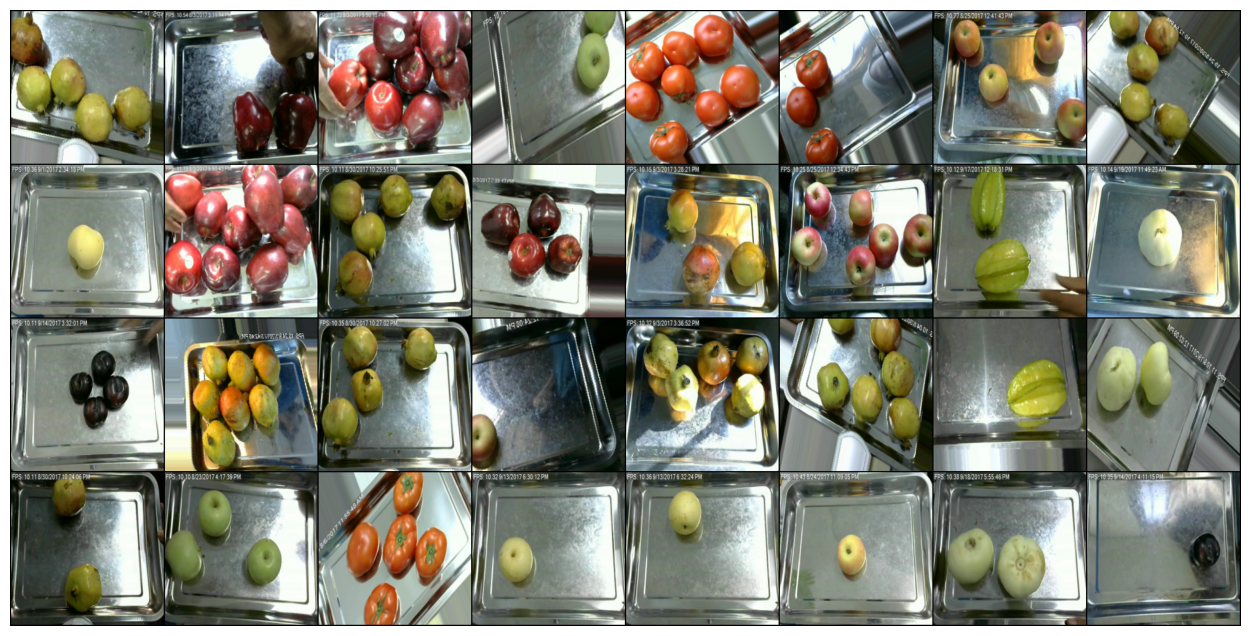

In [22]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

*This code iterates over the first batch of images from the training DataLoader. It prints the shape of the images tensor, displays them as a grid using `make_grid` and `matplotlib.pyplot.imshow`, and breaks the loop after processing the first batch.*

## Training model on GPU

# Create a simple function for accuracy evaluation


In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

*The `accuracy` function evaluates the accuracy of model predictions by comparing predicted class labels with true labels. It calculates the accuracy as the ratio of correct predictions to the total number of predictions.*

# Create a base model class (without architecture)

In [24]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

*The `ImageClassificationBase` class defines methods for training and validating image classification models. It calculates training loss, validation loss, and accuracy. The `epoch_end` method prints validation results at the end of each epoch.*

# Create training and evaluation functions

In [25]:

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Diagnostics: Print outputs and labels shapes
            outputs = model(images)

            # Forward pass
            loss = F.cross_entropy(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


The `evaluate` function assesses the model's performance on the validation set, aggregating results. The `fit` function trains the model over specified epochs, updating parameters using SGD optimizer, and records validation history.

# Check the availability of GPU

In [26]:
torch.cuda.is_available()

False

*The code checks whether a GPU (CUDA) is available on the system by using `torch.cuda.is_available()`. It returns a boolean indicating whether CUDA is available for accelerating computations with PyTorch.*

# Create a function to access the GPU (or CPU if not available)

In [27]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

*The `get_default_device` function checks for the availability of a CUDA-enabled GPU. If present, it returns the 'cuda' device; otherwise, it returns the 'cpu' device. The result is assigned to the `device` variable for PyTorch computations.*

# Create a function to move data to the GPU


In [28]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

*The `to_device` function moves PyTorch tensors to a specified device, and the `DeviceDataLoader` class wraps a DataLoader, ensuring batches are automatically transferred to the specified device during iteration.*

# Functions for displaying model loss and accuracy

In [29]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

*The `plot_losses` and `plot_accuracies` functions visualize training history. They extract and plot validation losses and accuracies against the number of epochs, providing insights into the model's performance during training.*

# Load the data onto the GPU

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

*The code wraps the training, validation, and test loaders using the `DeviceDataLoader` class, ensuring that batches are moved to the specified device (`device`) during iteration for efficient GPU or CPU-based computations.*

# Define the input size (image tensor size) and output size (number of classes)

In [31]:
input_size = 3*248*248
output_size = 7

*The `input_size` variable denotes the total features in an image with three color channels (RGB) and dimensions 248x248 pixels. `output_size` represents the number of output classes in a classification task, here set to 7.*

# Expand the initial model by adding the  SIMPLE NUERAL NETWORK architecture

In [32]:
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 128)
        self.linear2 = nn.Linear(128, 32)
        self.linear3 = nn.Linear(32, out_size)

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

*The `FruitRecognitionModel` class is a Simple neural network for fruit recognition, inheriting from `ImageClassificationBase`. It consists of three linear layers with ReLU activations, transforming input images into flattened vectors and progressively reducing dimensions. The architecture is defined in the constructor, and the forward pass is implemented in the `forward` method.*

# Move the model to the GPU

In [33]:
model = to_device(FruitRecognitionModel(input_size, out_size=output_size), device)
to_device(model, device)

FruitRecognitionModel(
  (linear1): Linear(in_features=184512, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=7, bias=True)
)

*The code creates an instance of the `FruitRecognitionModel` class, with input size specified by `input_size` and output size by `output_size`. The resulting model is then moved to the specified device (`device`) using the `to_device` function.*

# Check accuracy and losses on the validation set

In [34]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.9385113716125488, 'val_acc': 0.1346726268529892}]

*The code evaluates the initial performance of the `model` on the validation set (`val_loader`) and stores the result in a list named `history`. The `evaluate` function is called to compute and capture the validation loss and accuracy for the initial model. The resulting `history` provides insights into the model's initial performance.*

In [ ]:
%%time
history += fit(20, 0.01, model, train_loader, val_loader)


Epoch [0], val_loss: 0.6084, val_acc: 0.7903
Epoch [1], val_loss: 0.4740, val_acc: 0.8217
Epoch [2], val_loss: 0.3593, val_acc: 0.8627
Epoch [3], val_loss: 0.3357, val_acc: 0.8679


*This code block trains the neural network model (model) for 20 epochs with a learning rate of 0.01, records the training history, and displays the execution time. The fit function handles the training process, and adjustments to hyperparameters can be made based on experimentation.*

# Plot the loss graph

In [ ]:
plot_losses(history)

*The `plot_losses(history)` function is used to visualize the training history by plotting the validation losses against the number of epochs. This allows you to observe how the model's loss changes during training, providing insights into its convergence and performance.*

# Plot the accuracy graph

In [ ]:
plot_accuracies(history)

*The `plot_accuracies(history)` function is employed to create a plot depicting the validation accuracies over the course of training. This visualization helps assess the model's learning progress and performance on the validation set across different epochs.*

# Evaluate the model on the test set

In [ ]:
evaluate(model, test_loader)

*The code evaluates the trained `model` on the test set (`test_loader`) using the `evaluate` function. This provides an assessment of the model's performance on unseen data, computing the test set's loss and accuracy based on the model's predictions.*

# Save the model

In [ ]:
torch.save(model.state_dict(), 'fruit-recognition-model.pth')

*The code saves the state dictionary of the trained `model` to a file named 'fruit-recognition-model.pth' using PyTorch's `torch.save` function. This file can be later used to reload the model's parameters and architecture for inference or further training.*